# Probabilistic Roadmap


In this notebook you'll expand on previous random sampling exercises by creating a graph from the points and running A*.

1. Load the obstacle map data
2. Sample nodes (use KDTrees here)
3. Connect nodes (use KDTrees here)
4. Visualize graph
5. Define heuristic
6. Define search method
7. Execute and visualize

We'll load the data for you and provide a template for visualization.

In [1]:
# Again, ugly but we need the latest version of networkx!
# This sometimes fails for unknown reasons, please just 
# "reset and clear output" from the "Kernel" menu above 
# and try again!
import sys
#!{sys.executable} -m pip install -I networkx==2.1
import pkg_resources
#pkg_resources.require("networkx==2.1")
import networkx as nx

In [2]:
nx.__version__ # should be 2.1

'2.1'

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point, LineString
from queue import PriorityQueue
from sklearn.neighbors import KDTree
import numpy.linalg as LA

%matplotlib inline

In [4]:
plt.rcParams['figure.figsize'] = 14, 14

## Step 1 - Load Data

In [5]:
# This is the same obstacle data from the previous lesson.
filename = 'colliders.csv'
data = np.loadtxt(filename, delimiter=',', dtype='Float64', skiprows=2)
print(data)

[[-310.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-300.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-290.2389   -439.2315     85.5         5.          5.         85.5     ]
 ...
 [ 257.8061    425.1645      1.75852     1.292725    1.292725    1.944791]
 [ 293.9967    368.3391      3.557666    1.129456    1.129456    3.667319]
 [ 281.5162    354.4156      4.999351    1.053772    1.053772    4.950246]]


## Step 2 - Sample Points


You may want to limit the z-axis values.

-310.2389

In [40]:
import numpy
x = np.array(data[50])
for i in range(data.shape[0]):
    if numpy.array_equal(data[i], y):  
        indx = i
        print(data[indx-3:indx+4,:])

[[-160.2389  -419.2315    46.         5.         5.        46.     ]
 [-120.2389  -419.2315    26.5        5.         5.        26.5    ]
 [-110.2389  -419.2315    27.5        5.         5.        27.5    ]
 [-100.2389  -419.2315     8.         5.         5.         8.     ]
 [ -90.23886 -419.2315     8.         5.         5.         8.     ]
 [ -80.23886 -419.2315     8.         5.         5.         8.     ]
 [ -70.23886 -419.2315     8.         5.         5.         8.     ]]


In [41]:
print(indx)

100


In [6]:
#built up class for KDTree, simplifies sampling and other operations 
from sampling import Sampler

In [7]:
#build a sampler object on the Data we have // CSV File. then construct polygon objects
sampler = Sampler(data)
polygons = sampler._polygons

In [72]:
nodes = sampler.sample(100)
print(len(nodes))

65


In [73]:
'''# TODO: sample points randomly
# then use KDTree to find nearest neighbor polygon
# and test for collision
np.random.seed()
points = np.random.random((50, 3))
tree = KDTree(points)
index = []
for p in points:
    indx = tree.query([p], k=3, return_distance = False)[0]
'''

'# TODO: sample points randomly\n# then use KDTree to find nearest neighbor polygon\n# and test for collision\nnp.random.seed()\npoints = np.random.random((50, 3))\ntree = KDTree(points)\nindex = []\nfor p in points:\n    indx = tree.query([p], k=3, return_distance = False)[0]\n'

## Step 3 - Connect Nodes

Now we have to connect the nodes. There are many ways they might be done, it's completely up to you. The only restriction being no edge connecting two nodes may pass through an obstacle.

NOTE: You can use `LineString()` from the `shapely` library to create a line. Additionally, `shapely` geometry objects have a method `.crosses` which return `True` if the geometries cross paths, for instance your `LineString()` with an obstacle `Polygon()`!

In [74]:
# TODO: connect nodes
# Suggested method
       # 1) write a method "can_connect()" that:
        # casts two points as a shapely LineString() object
        # tests for collision with a shapely Polygon() object
        # returns True if connection is possible, False otherwise
def can_connect(p1, p2):
    line = LineString([p1,p2])
    for p in polygons:
         if p.crosses(line) and p.height >= min(p1[2],p2[2]):
            return False
    return True
    # 2) cast nodes into a graph called "g" using networkx
     # 3) write a method "create_graph()" that:
        # defines a networkx graph as g = Graph()
        # defines a tree = KDTree(nodes)
        # test for connectivity between each node and 
            # k of it's nearest neighbors
        # if nodes are connectable, add an edge to graph
    # Iterate through all candidate nodes!
def create_graph(nodes, k):
    graph = nx.Graph()
    tree = KDTree(nodes)
    for n1 in nodes: 
        idx = tree.query([n1], k, return_distance = False)[0]
        for i in idx:
            n2 = nodes[i]
            if n2 == n1:
                continue
            if can_connect(n1,n2):
                graph.add_edge(n1,n2,weight=1)
    return graph
            

In [109]:
#run the create_graph function on attributes to actually construct the graph
graph = create_graph(nodes, 10)

## Step 4 - Visualize Graph

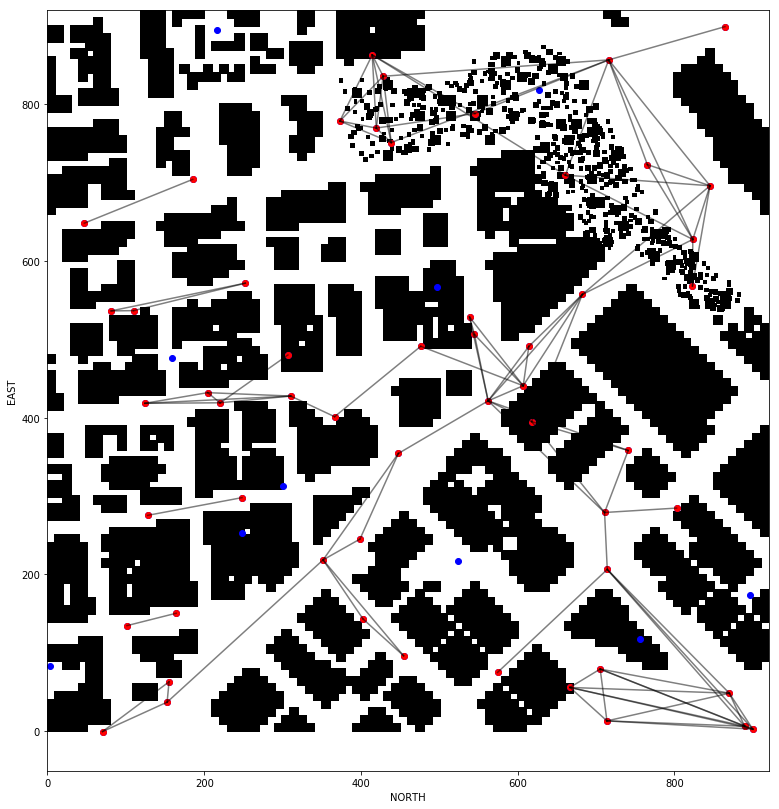

In [110]:
# Create a grid map of the world
from grid import create_grid
# This will create a grid map at 1 m above ground level
grid = create_grid(data, 1, 1)

fig = plt.figure()

plt.imshow(grid, cmap='Greys', origin='lower')

nmin = np.min(data[:, 0])
emin = np.min(data[:, 1])

# If you have a graph called "g" these plots should work
# Draw edges
for (n1, n2) in graph.edges:
    plt.plot([n1[1] - emin, n2[1] - emin], [n1[0] - nmin, n2[0] - nmin], 'black' , alpha=0.5)

# Draw all nodes connected or not in blue
for n1 in nodes:
    plt.scatter(n1[1] - emin, n1[0] - nmin, c='blue')
    
# Draw connected nodes in red
for n1 in graph.nodes:
    plt.scatter(n1[1] - emin, n1[0] - nmin, c='red')
    


plt.xlabel('NORTH')
plt.ylabel('EAST')

plt.show()

## Step 5 - Define Heuristic

In [111]:
def heuristic(n1, n2):
    cost = LA.norm(np.array(n2) - np.array(n1))
    return cost

## Step 6 - Complete A*

In [112]:
def a_star(graph, heuristic, start, goal):
    """Modified A* to work with NetworkX graphs."""
    path = []
    queue = PriorityQueue()
    queue.put((0,start))
    visited = set(start)
    
    branch = {}
    found = False
    while not queue.empty():
        item = queue.get()
        current_cost = item[0]
        current_node = item[1]
        
        if current_node == goal:
            found = True
            print('Path Found!')
            break
        else:
            for next_node in graph[current_node]:
                cost = graph.edges[current_node, next_node]['weight']
                new_cost = current_cost + cost + heuristic(next_node, goal)
            if next_node not in visited:
                visited.add((next_node))
                queue.put((new_cost, next_node))
                branch[next_node] = (new_cost, current_node)
    # TODO: complete
    path = []
    path_cost = 0
    if found:
        
        # retrace steps
        path = []
        n = goal
        path_cost = branch[n][0]
        while branch[n][1] != start:
            path.append(branch[n][1])
            n = branch[n][1]
        path.append(branch[n][1])
            
    return path[::-1], path_cost



In [134]:
start = list(graph.nodes)[0]
k = np.random.randint(len(graph.nodes))
print(k, len(graph.nodes))
goal = list(graph.nodes)[k]
print('start :', start)
print('goal :', goal)

6 55
start : (385.67264171583298, 406.17216999661514, 10.392553994033459)
goal : (246.9358414730512, 243.25929083457049, 18.892966610075597)


In [135]:
path, cost = a_star(graph, heuristic, start, goal)
print(len(path), path)

Path Found!
1 [(385.67264171583298, 406.17216999661514, 10.392553994033459)]


In [129]:
path_pairs = zip(path[:-1], path[1:])
for (n1, n2) in path_pairs:
    print(n1, n2)

(385.67264171583298, 406.17216999661514, 10.392553994033459) (246.9358414730512, 243.25929083457049, 18.892966610075597)
(246.9358414730512, 243.25929083457049, 18.892966610075597) (111.22182840713327, 123.0989131524716, 15.399729868970581)


## Step 7 - Visualize Path

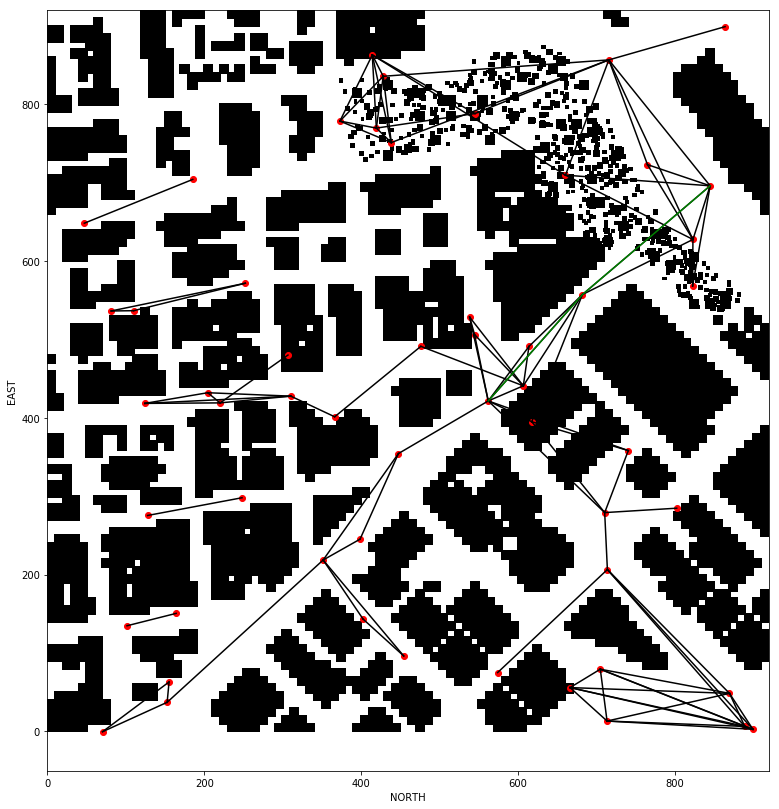

In [130]:
fig = plt.figure()

plt.imshow(grid, cmap='Greys', origin='lower')

nmin = np.min(data[:, 0])
emin = np.min(data[:, 1])

# draw nodes
for n1 in graph.nodes:
    plt.scatter(n1[1] - emin, n1[0] - nmin, c='red')
    
# draw edges
for (n1, n2) in graph.edges:
    plt.plot([n1[1] - emin, n2[1] - emin], [n1[0] - nmin, n2[0] - nmin], 'black')
    
# TODO: add code to visualize the path
path_pairs = zip(path[:-1], path[1:])
for (n1, n2) in path_pairs:
    plt.plot([n1[1] - emin, n2[1] - emin], [n1[0] - nmin, n2[0] - nmin], 'green')


plt.xlabel('NORTH')
plt.ylabel('EAST')

plt.show()

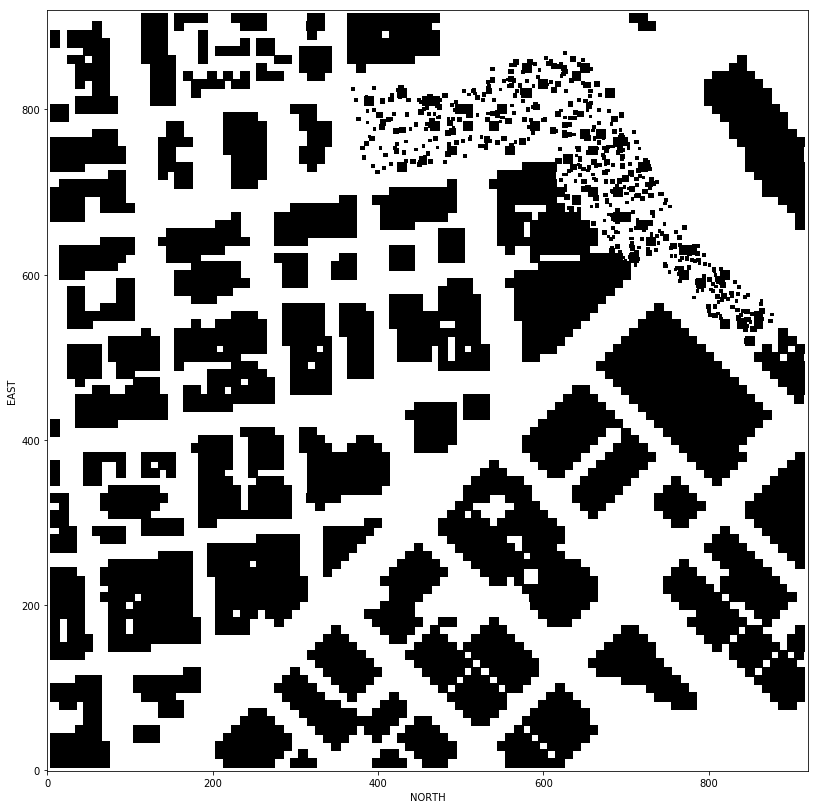

In [13]:
fig = plt.figure()

plt.imshow(grid, cmap='Greys', origin='lower')

# Add code to visualize path here

plt.xlabel('NORTH')
plt.ylabel('EAST')

plt.show()

[solution](/notebooks/Probabilistic-Roadmap-Solution.ipynb)